<a href="https://colab.research.google.com/github/evany50/Cloud-Storage-Benchmark/blob/main/Cloud_Storage_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud Storage Benchmark

In [25]:
!pip install "boto3==1.24.96" "botocore==1.27.96"

[small] B2 - Upload: 0.089s, Download: 0.045s
[small] R2 - Upload: 0.292s, Download: 0.146s
[small] IBM - Upload: 0.449s, Download: 0.507s
[medium] B2 - Upload: 0.278s, Download: 0.066s
[medium] R2 - Upload: 0.697s, Download: 0.252s
[medium] IBM - Upload: 0.453s, Download: 0.311s
[large] B2 - Upload: 5.265s, Download: 2.276s
[large] R2 - Upload: 1.103s, Download: 0.378s
[large] IBM - Upload: 1.832s, Download: 0.282s


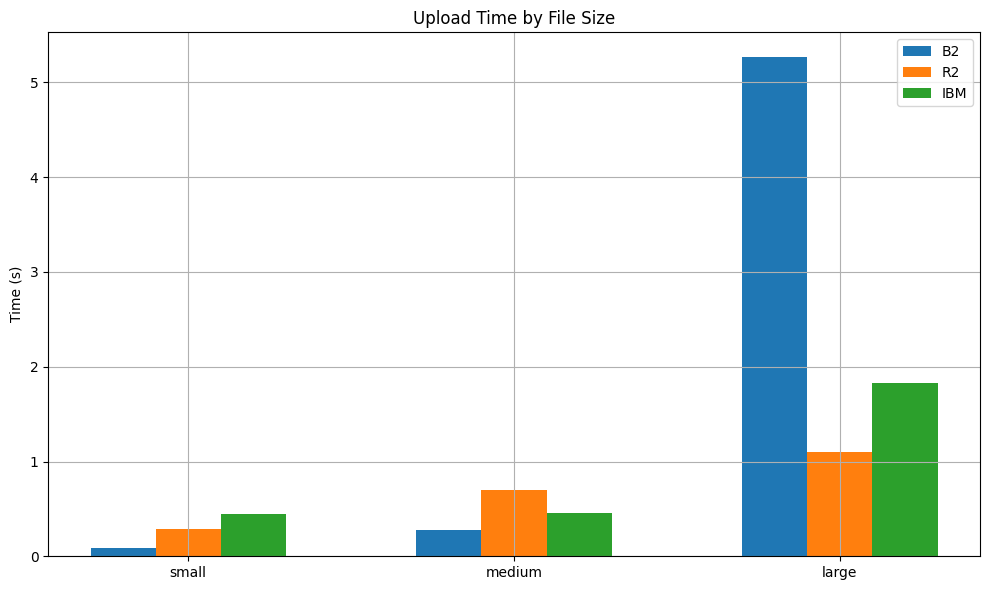

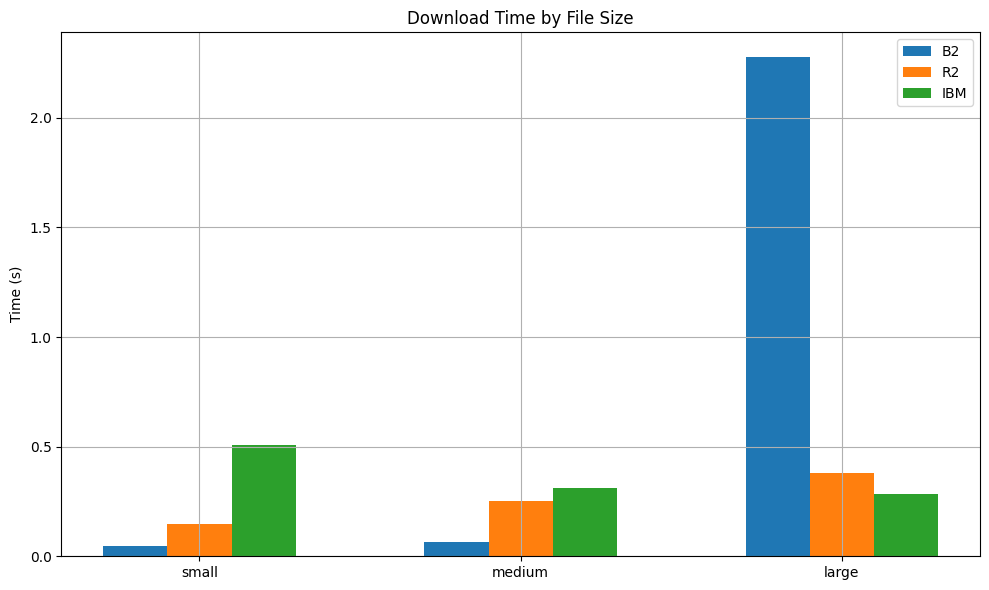

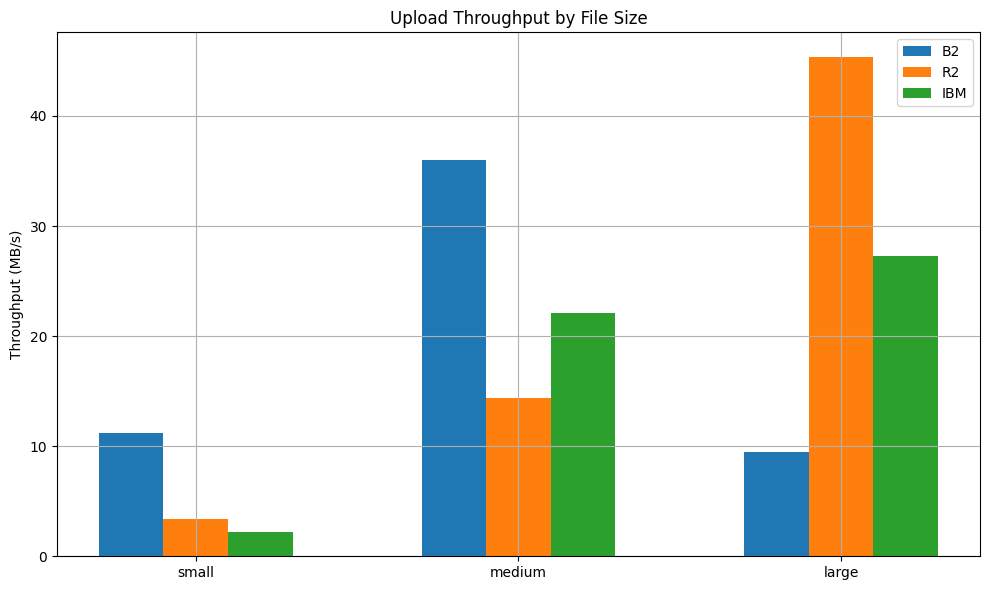

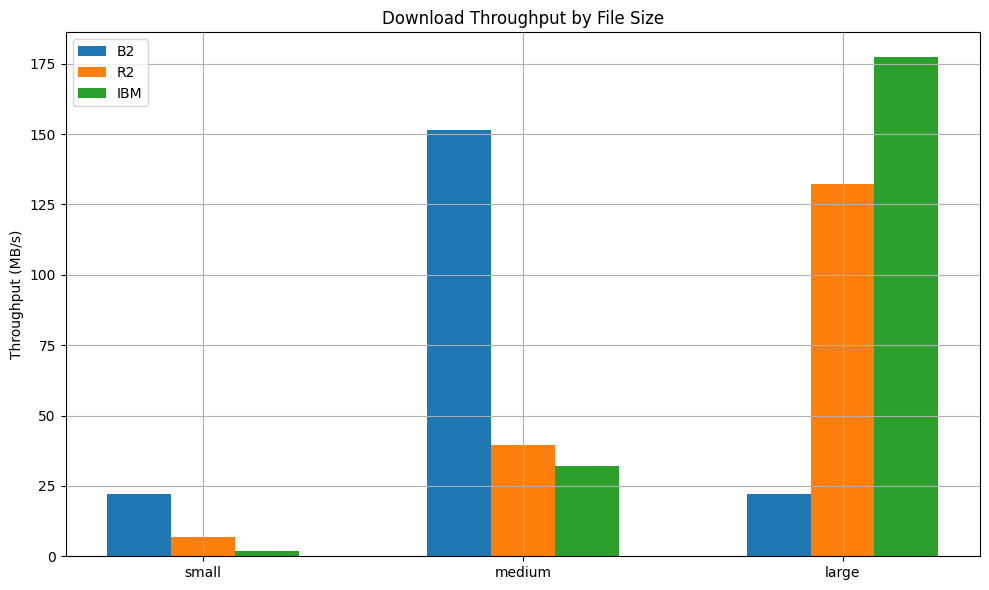

In [26]:
import boto3
import time
import os
import matplotlib.pyplot as plt
from botocore.client import Config
from google.colab import userdata
from collections import defaultdict
from functools import partial

# Constants
MB = 1_000_000  # Bytes in 1 MB

# Config for each provider
PROVIDERS = {
    'b2': {
        'endpoint': 'https://s3.us-east-005.backblazeb2.com',
        'bucket': '4740-b2',
        'access_key': userdata.get('B2_ACCESS_KEY'),
        'secret_key': userdata.get('B2_SECRET_KEY'),
        'region': 'us-east-005'
    },
    'r2': {
        'endpoint': 'https://bff458e6721fda28bc1784d898942c56.r2.cloudflarestorage.com',
        'bucket': 'cs4740-cloudflare',
        'access_key': userdata.get('R2_ACCESS_KEY'),
        'secret_key': userdata.get('R2_SECRET_KEY'),
        'region': 'auto'
    },
    'ibm': {
        'endpoint': 'https://s3.us-east.cloud-object-storage.appdomain.cloud',
        'bucket': 'cs4740-ibm',
        'access_key': userdata.get('IBM_ACCESS_KEY'),
        'secret_key': userdata.get('IBM_SECRET_KEY'),
        'region': 'us-east'
    }
}

# Files to test with their sizes in MB
FILES = {
    'small': ('test_1MB.txt', 1),
    'medium': ('test_10MB.txt', 10),
    'large': ('test_50MB.txt', 50)
}

def create_s3_client(config):
    # Create and return a configured S3 client
    return boto3.client(
        's3',
        region_name=config['region'],
        endpoint_url=config['endpoint'],
        aws_access_key_id=config['access_key'],
        aws_secret_access_key=config['secret_key'],
        config=Config(signature_version='s3v4', s3={'addressing_style': 'path'})
    )

def time_operation(operation, *args, **kwargs):
    # Time an operation and return the duration in seconds
    start = time.perf_counter()
    operation(*args, **kwargs)
    return round(time.perf_counter() - start, 3)

def generate_test_file(file_path, size_mb):
    # Generate a test file of specified size if it doesn't exist
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(os.urandom(size_mb * MB))

def calculate_throughput(size_mb, time_sec):
    # Calculate throughput in MB/s
    return round(size_mb / time_sec, 2) if time_sec else 0

def run_benchmark(runs=5):
    # Run the benchmark tests for all providers and file sizes
    results = {
        'upload': defaultdict(dict),
        'download': defaultdict(dict),
        'upload_throughput': defaultdict(dict),
        'download_throughput': defaultdict(dict)
    }

    for label, (file_path, file_size_mb) in FILES.items():
        generate_test_file(file_path, file_size_mb)

        for provider, cfg in PROVIDERS.items():
            s3 = create_s3_client(cfg)
            object_name = f"{label}_{file_path}"
            downloaded_file = f"downloaded_{object_name}"

            # Partial functions to avoid repeating parameters
            upload_op = partial(s3.upload_file, file_path, cfg['bucket'], object_name)
            download_op = partial(s3.download_file, cfg['bucket'], object_name, downloaded_file)

            # Time operations
            upload_times = [time_operation(upload_op) for _ in range(runs)]
            download_times = [time_operation(download_op) for _ in range(runs)]

            # Calculate averages
            avg_upload = round(sum(upload_times) / runs, 3)
            avg_download = round(sum(download_times) / runs, 3)

            # Store results
            results['upload'][label][provider] = avg_upload
            results['download'][label][provider] = avg_download
            results['upload_throughput'][label][provider] = calculate_throughput(file_size_mb, avg_upload)
            results['download_throughput'][label][provider] = calculate_throughput(file_size_mb, avg_download)

            print(f"[{label}] {provider.upper()} - Upload: {avg_upload}s, Download: {avg_download}s")

    return results

def plot_results(results):
    # Plot the benchmark results
    labels = list(FILES.keys())
    providers = list(PROVIDERS.keys())
    x = range(len(labels))
    width = 0.2

    def create_plot(data, ylabel, title):
        plt.figure(figsize=(10, 6))
        for idx, provider in enumerate(providers):
            values = [data[label][provider] for label in labels]
            plt.bar([p + width*idx for p in x], values, width, label=provider.upper())
        plt.xticks([p + width for p in x], labels)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Create plots for each metric
    create_plot(results['upload'], "Time (s)", "Upload Time by File Size")
    create_plot(results['download'], "Time (s)", "Download Time by File Size")
    create_plot(results['upload_throughput'], "Throughput (MB/s)", "Upload Throughput by File Size")
    create_plot(results['download_throughput'], "Throughput (MB/s)", "Download Throughput by File Size")

# Run the benchmark and plot results
benchmark_results = run_benchmark(runs=5)
plot_results(benchmark_results)